In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout


In [2]:
# Load the dataset
df = pd.read_csv("C://Users//mohammed luqmaan//OneDrive//Desktop//Datasets//train.csv").fillna('')

# Combine all text columns into a single column
df['text'] = df['comment_text']

# Encode the labels
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
df[label_cols] = df[label_cols].astype(int)


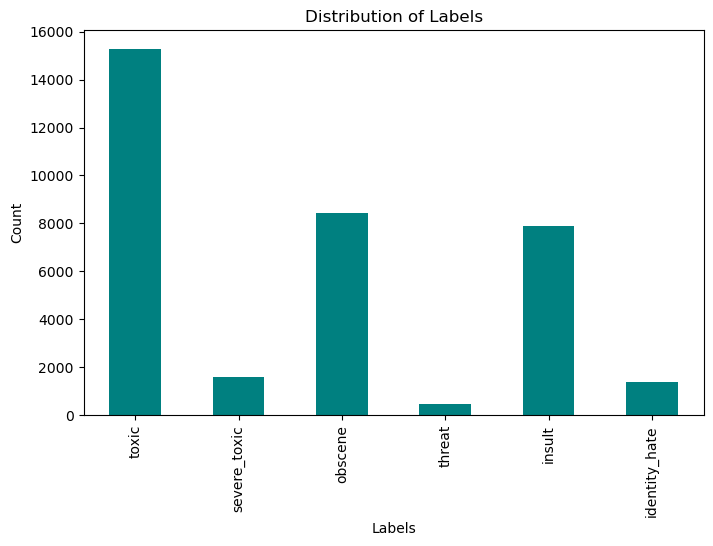

In [3]:
# Visualize label distribution
plt.figure(figsize=(8, 5))
df[label_cols].sum().plot(kind='bar', color='teal')
plt.title('Distribution of Labels')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()


In [4]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(df['text'], df[label_cols], test_size=0.2, random_state=42)


<Figure size 1000x600 with 0 Axes>

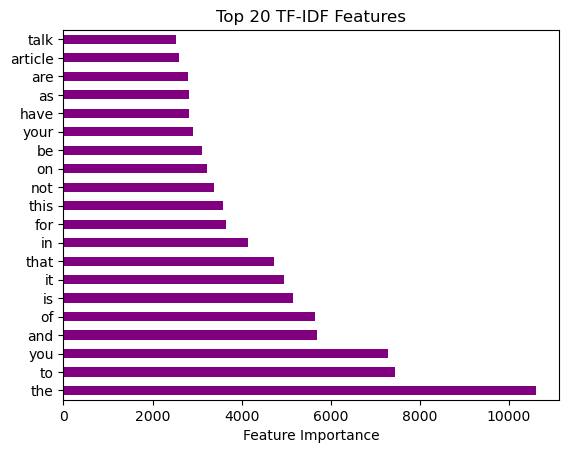

In [5]:
# TF-IDF Vectorization for Random Forest
tfidf = TfidfVectorizer(max_features=10000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Visualize TF-IDF feature importance for first few features
tfidf_feature_names = tfidf.get_feature_names_out()
top_n = 20  # Number of top features to visualize
top_tfidf = pd.DataFrame(X_train_tfidf.sum(axis=0), columns=tfidf_feature_names).T.sort_values(0, ascending=False).head(top_n)
plt.figure(figsize=(10, 6))
top_tfidf.plot(kind='barh', legend=False, color='purple')
plt.title('Top 20 TF-IDF Features')
plt.xlabel('Feature Importance')
plt.show()


Random Forest Classification Report:
               precision    recall  f1-score   support

        toxic       0.92      0.58      0.71      3056
 severe_toxic       0.51      0.08      0.14       321
      obscene       0.90      0.64      0.75      1715
       threat       0.50      0.05      0.10        74
       insult       0.82      0.46      0.59      1614
identity_hate       0.79      0.06      0.12       294

    micro avg       0.89      0.52      0.65      7074
    macro avg       0.74      0.31      0.40      7074
 weighted avg       0.87      0.52      0.64      7074
  samples avg       0.05      0.04      0.05      7074

Random Forest Accuracy: 0.92


c:\Users\mohammed luqmaan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mohammed luqmaan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


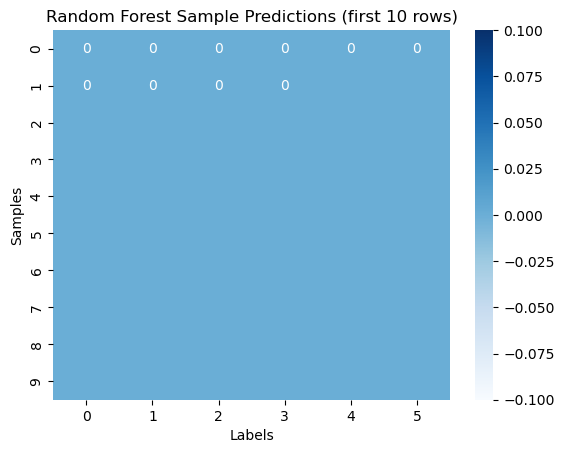

In [6]:
# Train the Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_tfidf, y_train)

# Predict and evaluate Random Forest
y_pred_rf = rf.predict(X_test_tfidf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=label_cols))
print(f"Random Forest Accuracy: {accuracy_rf:.2f}")

# Visualize Random Forest prediction distribution
sns.heatmap(y_pred_rf[:10], annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Sample Predictions (first 10 rows)')
plt.xlabel('Labels')
plt.ylabel('Samples')
plt.show()


In [7]:
# Tokenization and padding for LSTM
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)
X_train_pad = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=100)
X_test_pad = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=100)


Epoch 1/2


c:\Users\mohammed luqmaan\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1596/1596 ━━━━━━━━━━━━━━━━━━━━ 872s 543ms/step - accuracy: 0.9741 - loss: 0.1334 - val_accuracy: 0.9943 - val_loss: 0.0568
Epoch 2/2
1596/1596 ━━━━━━━━━━━━━━━━━━━━ 242s 152ms/step - accuracy: 0.9939 - loss: 0.0544 - val_accuracy: 0.9943 - val_loss: 0.0538


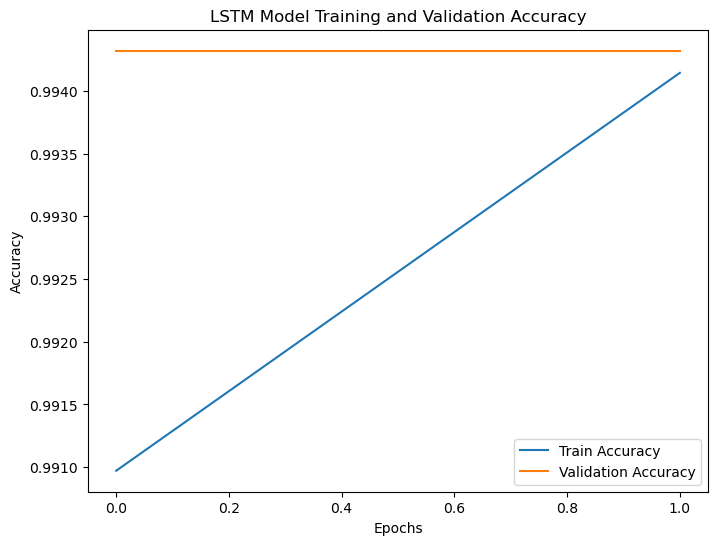

In [9]:
# Build the LSTM model
model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=100),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dense(6, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the LSTM model with training visualization
history = model.fit(X_train_pad, y_train, epochs=2, batch_size=64, validation_split=0.2)

# Plot training history for LSTM model
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Model Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


998/998 ━━━━━━━━━━━━━━━━━━━━ 34s 34ms/step
LSTM Classification Report:
               precision    recall  f1-score   support

        toxic       0.90      0.64      0.75      3056
 severe_toxic       0.72      0.04      0.08       321
      obscene       0.90      0.62      0.73      1715
       threat       0.00      0.00      0.00        74
       insult       0.77      0.55      0.64      1614
identity_hate       0.00      0.00      0.00       294

    micro avg       0.87      0.56      0.68      7074
    macro avg       0.55      0.31      0.37      7074
 weighted avg       0.81      0.56      0.65      7074
  samples avg       0.06      0.05      0.05      7074

LSTM Accuracy: 0.92


c:\Users\mohammed luqmaan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mohammed luqmaan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mohammed luqmaan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


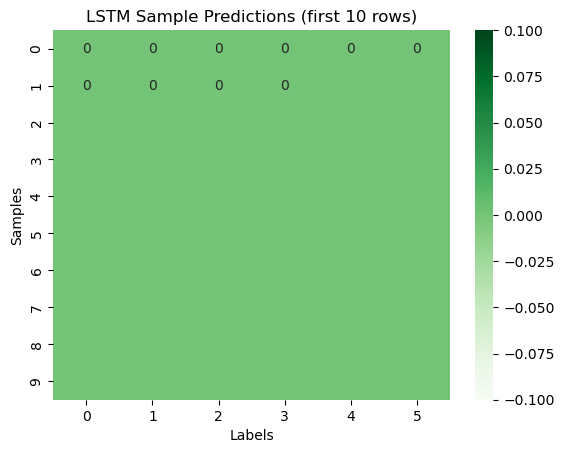

In [10]:
# Predict and evaluate LSTM
y_pred_lstm = (model.predict(X_test_pad) > 0.5).astype(int)
accuracy_lstm = accuracy_score(y_test, y_pred_lstm)
print("LSTM Classification Report:")
print(classification_report(y_test, y_pred_lstm, target_names=label_cols))
print(f"LSTM Accuracy: {accuracy_lstm:.2f}")

# Visualize LSTM prediction distribution
sns.heatmap(y_pred_lstm[:10], annot=True, fmt='d', cmap='Greens')
plt.title('LSTM Sample Predictions (first 10 rows)')
plt.xlabel('Labels')
plt.ylabel('Samples')
plt.show()


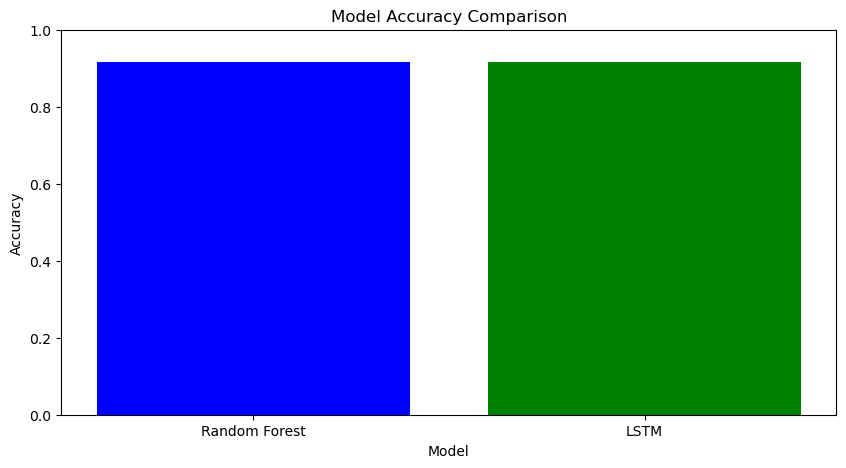

In [11]:
# Visualization - Compare Model Accuracy
models = ['Random Forest', 'LSTM']
accuracies = [accuracy_rf, accuracy_lstm]

plt.figure(figsize=(10, 5))
plt.bar(models, accuracies, color=['blue', 'green'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)
plt.show()
